# Dec 15, 2023, Jan 6, 2024: pca dimensionality reduction of time series

In [1]:
import csv
import os
import sys
import numpy as np
import pandas as pd
import scipy as sp 
import pickle 
from os.path import join as pjoin
from itertools import product, combinations
from tqdm import tqdm
from copy import deepcopy
from pathlib import Path
import subprocess
from scipy import sparse, stats
from multiprocessing import Pool

import ssm

from sklearn.decomposition import PCA
# networks
import networkx as nx
import ants
from nipype.interfaces import afni

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import rainbow

plt.rcParamsDefault['font.family'] = "sans-serif"
plt.rcParamsDefault['font.sans-serif'] = "Arial"
plt.rcParams['font.size'] = 14
plt.rcParams["errorbar.capsize"] = 0.5

import cmasher as cmr  # CITE ITS PAPER IN YOUR MANUSCRIPT

# ignore user warnings
import warnings
warnings.filterwarnings("ignore") #, category=UserWarning)

240126-12:02:30,203 nipype.utils WARNING:
	 A newer version (1.8.4) of nipy/nipype is available. You are using 1.6.1


In [2]:
class ARGS():
    pass

args = ARGS()

In [3]:
args.parcel_name = 'whole'
args.rois_folder = 'yale_56' # 'yale_172' # 'hadi_1445'

hadi_1445_img = (
    f'{os.environ["HOME"]}/mouse_dataset/allen_atlas_ccfv3/hadi/parcellation'
    f'/warped_on_n162/{args.parcel_name}_parcels_warped_cm.nii.gz'
)
yale_172_img = (
    f'{os.environ["HOME"]}/mouse_dataset' 
    f'/n162_parcellations/172_parcels_RAS_cm.nii.gz'
)
yale_56_img = (
    f'{os.environ["HOME"]}/mouse_dataset' 
    f'/n162_parcellations/56_parcels_RAS_cm.nii.gz'
)

hadi_1445_rois = (
    f'{os.environ["HOME"]}/mouse_dataset/allen_atlas_ccfv3/hadi/parcellation'
    f'/warped_on_n162/{args.parcel_name}_roi_labels.txt'
)
yale_172_rois = (
    f'{os.environ["HOME"]}/mouse_dataset' 
    f'/n162_parcellations/172_roi_labels.txt'
)
yale_56_rois = (
    f'{os.environ["HOME"]}/mouse_dataset' 
    f'/n162_parcellations/56_roi_labels.txt'
)

parcels_img = ants.image_read(yale_56_img)
parcels = parcels_img.numpy()
roi_labels = np.loadtxt(yale_56_rois)
roi_labels.shape

(56,)

In [4]:
args.parcel_name = 'whole'
args.rois_folder = 'yale_56' #'yale_172' # 'hadi_1445'
COLLECT_path = f'/home/govindas/mouse_dataset/voxel/all_file_collections'
BASE_path = f'{os.environ["HOME"]}/mouse_dataset/roi'
TS_path = f'{BASE_path}/{args.rois_folder}/roi_timeseries_txt_files/{args.parcel_name}'
RES_path = f'{BASE_path}/{args.rois_folder}/temp_states/{args.parcel_name}'
cmd = (
    f'mkdir -p {RES_path}'
)
os.system(cmd)

0

In [5]:
args.num_subs = 10
args.num_sess = 3
args.num_rois = roi_labels.shape[0]
args.tot_time = 600 # total time points

main_sample = [
    [
        []
        for ses in range(args.num_sess)
    ]
    for sub in range(args.num_subs)
]
for file in os.listdir(TS_path):
    fs = file.split('_')
    if int(fs[2].split('-')[-1]) % 2 == 0: continue # skip even runs
    sub = int(fs[0].split('-')[-1][-2:])
    ses = int(fs[1].split('-')[-1])
    main_sample[sub-1][ses-1].append(file)

for sub in np.arange(1,args.num_subs+1):
    for ses in np.arange(1, args.num_sess+1):
        main_sample[sub-1][ses-1] = list(np.sort(main_sample[sub-1][ses-1]))

In [6]:
def get_frame_censor_mask(run):
    identity = '_'.join(run.split('_')[:-1])
    collections_file = [f for f in os.listdir(COLLECT_path) if identity in f][0]
    with open(f'{COLLECT_path}/{collections_file}', 'r') as f:
        frm_csr_file = f.readlines()[0][:-1]
    with open(frm_csr_file, 'r') as f:
        frm_csr =  np.array([(v[:-1]) == 'True' for v in f.readlines()[1:]])
    return frm_csr

In [7]:
ts_sample = deepcopy(main_sample)
ts_all, mask_all = [], []
for sub, ses in tqdm(product(range(args.num_subs), range(args.num_sess))):
    ts_runs, mask_runs = [], []
    for run in main_sample[sub][ses]:
        ts = np.loadtxt(f'{TS_path}/{run}')
        ts = stats.zscore(ts, axis=0, nan_policy='omit') # time x rois
        ts = np.nan_to_num(ts)
        mask = get_frame_censor_mask(run)
        ts_big = np.zeros((args.tot_time, args.num_rois))
        # ts_big = np.random.randn(args.tot_time, args.num_rois)
        ts_big[mask, :] = ts
        mask = np.tile(mask[None, :].T, (1, args.num_rois)) # tot_time x rois
        
        ts_runs.append(ts_big)
        mask_runs.append(mask)
        ts_all.append(ts_big)
        mask_all.append(mask)
    ts_sample[sub][ses] = list(zip(ts_runs, mask_runs))

30it [00:00, 41.09it/s]


In [8]:
with open(f'{RES_path}/ts_sample_{args.num_rois}.npy', 'wb') as f:
    pickle.dump(ts_sample, f)

---

In [9]:
# PCA
args.var = 0.25 # variance explained
ts_all_stk = np.vstack(ts_all)
try:
    with open(f'{RES_path}/pca_ts_v-{args.var}.pkl', 'rb') as f:
        [pca, ts_all_pca, mask_all_pca] = pickle.load(f)
        args.num_comps = ts_all_pca[0].shape[-1]
        print(args.num_comps)
        ts_all_stk_pca = np.vstack(ts_all_pca)
        mask_all_stk_pca = np.vstack(mask_all_pca)
except:
    # find the suitable '# of components' to explain `args.var` variance in data
    pca = PCA(n_components=args.num_rois) 
    pca = pca.fit(ts_all_stk)
    c = np.cumsum(pca.explained_variance_ratio_)
    d = np.max(np.where(c <= args.var)[0])
    
    # fresh pca with found '# of components'
    pca = PCA(n_components=d)
    ts_all_stk_pca = pca.fit_transform(ts_all_stk)
    print(ts_all_stk_pca.shape)
    ts_all_pca = np.split(ts_all_stk_pca, len(ts_all))
    mask_all_pca = [mask[:, :d] for mask in mask_all]
    
    with open(f'{RES_path}/pca_ts_v-{args.var}.pkl', 'wb') as f:
        pickle.dump([pca, ts_all_pca, mask_all_pca], f)
    
    args.num_comps = ts_all_pca[0].shape[-1]
    assert args.num_comps == d

9


---

In [10]:
args.N_iters = 25
args.transitions = 'standard'
args.observations = 'gaussian'
for args.num_states in range(2, 10):
    try:
        with open(
            (
                f'{RES_path}'
                f'/hmm_v-{args.var}_k-{args.num_states}_trns-{args.transitions}_obs-{args.observations}.pkl'
            ), 
            'rb'
        ) as f:
            [hmm, lls] = pickle.load(f)
    except:
        print(f'D = {args.num_comps}, K = {args.num_states}')
        hmm = ssm.HMM(
            K=args.num_states,
            D=args.num_comps,
            transitions=args.transitions,
            observations=args.observations,
        )
        lls = hmm.fit(
            datas=ts_all_pca, 
            masks=mask_all_pca,
            method='em', 
            num_iters=args.N_iters, 
            init_method='kmeans',
        )
        with open(
            (
                f'{RES_path}'
                f'/hmm_v-{args.var}_k-{args.num_states}_trns-{args.transitions}_obs-{args.observations}.pkl'
            ), 
            'wb'
        ) as f:
            pickle.dump([hmm, lls], f)
        plt.plot(lls)

---

In [11]:
args.num_states = 7
with open(
        (
            f'{RES_path}'
            f'/hmm_v-{args.var}_k-{args.num_states}_trns-{args.transitions}_obs-{args.observations}.pkl'
        ), 
        'rb'
    ) as f:
        [hmm, lls] = pickle.load(f)

In [12]:
def _sccores(pi0, Ps, ll):
    """
    This is modified from pyhsmm.internals.hmm_states
    by Matthew Johnson.
    """
    LOG_EPS = 1e-16
    T, K = ll.shape

    # Check if the transition matrices are stationary or
    # time-varying (hetero)
    hetero = (Ps.shape[0] == T-1)
    if not hetero:
        assert Ps.shape[0] == 1

    # Pass max-sum messages backward
    scores = np.zeros((T, K))
    args = np.zeros((T, K))
    for t in range(T-2,-1,-1):
        vals = np.log(Ps[t * hetero] + LOG_EPS) + scores[t+1] + ll[t+1]
        for k in range(K):
            args[t+1, k] = np.argmax(vals[k])
            scores[t, k] = np.max(vals[k])

    # # Now maximize forwards
    # z = np.zeros(T)
    # z[0] = (scores[0] + np.log(pi0 + LOG_EPS) + ll[0]).argmax()
    # for t in range(1, T):
    #     z[t] = args[t, int(z[t-1])]

    return scores, args

def _state_scores(hmm, data, input=None, mask=None, tag=None):
    pi0 = hmm.init_state_distn.initial_state_distn
    Ps = hmm.transitions.transition_matrices(data, input, mask, tag)
    log_likes = hmm.observations.log_likelihoods(data, input, mask, tag)
    return _sccores(pi0, Ps, log_likes)

Text(0.5, 1.0, 'state transition probs.')

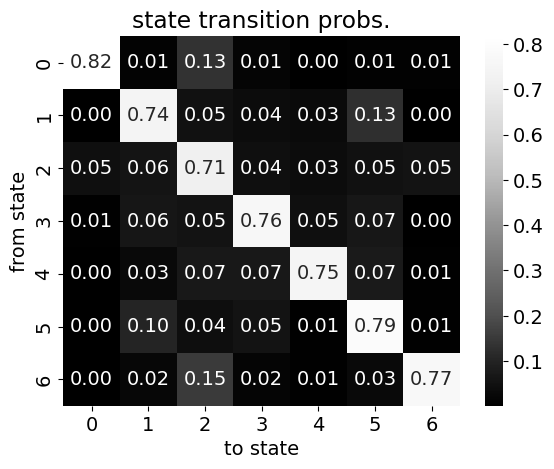

In [13]:
# state transiton matrix
sns.heatmap(hmm.transitions.transition_matrix, cmap='Greys_r', annot=True, fmt='.2f')
plt.xlabel('to state')
plt.ylabel('from state')
plt.title('state transition probs.')

Text(0.5, 0, 'time (sec)')

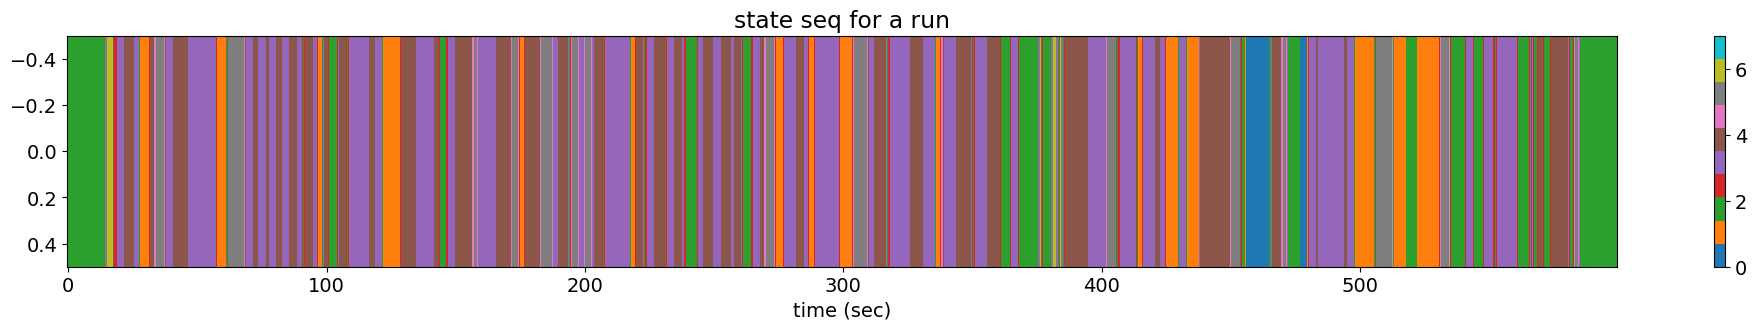

In [14]:
# state sequence
plt.figure(figsize=(25, 3))
plt.imshow(
    hmm.most_likely_states(ts_all_pca[27], mask=mask_all_pca[27])[None, :], 
    aspect='auto',
    cmap='tab10',
    vmin=0, 
    vmax=args.num_states,
)
plt.colorbar()
plt.title('state seq for a run')
plt.xlabel('time (sec)')

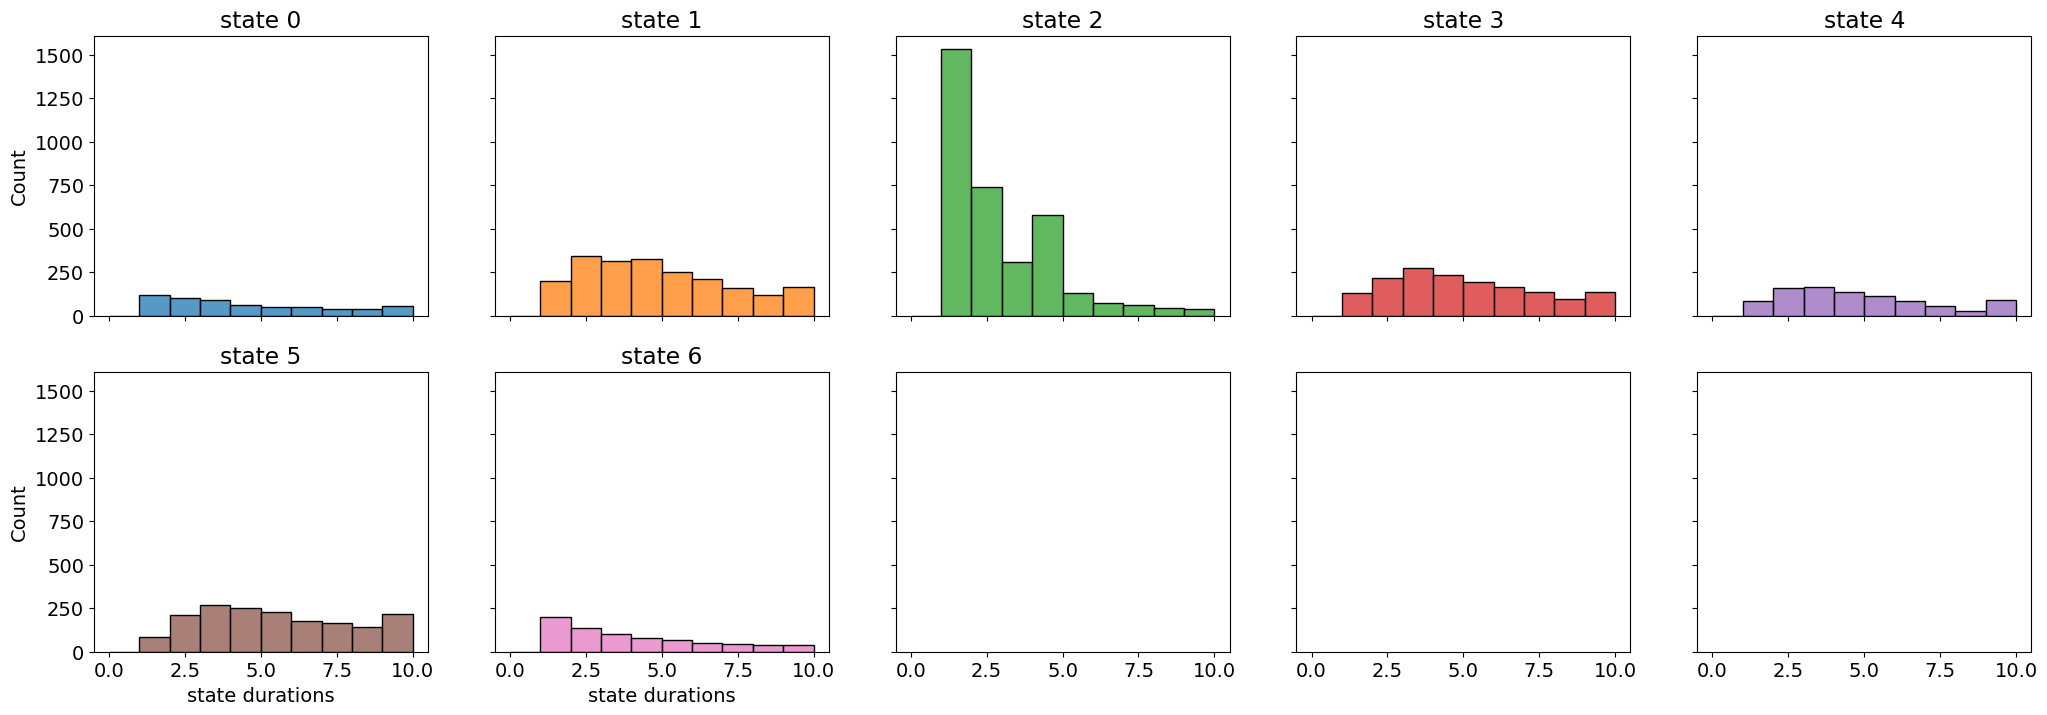

In [15]:
# contiguous blocks of states
state_seq = hmm.most_likely_states(data=ts_all_stk_pca, mask=mask_all_stk_pca)
durs_stacked = [[] for _ in range(args.num_states)]
st_list, durs = ssm.util.rle(state_seq)
for s in range(args.num_states):
    durs_stacked[s] = durs[st_list == s]

colors = sns.color_palette('tab10')[:hmm.K]
nrows, ncols = int(np.ceil(args.num_states / 5)), 5
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5*ncols, 4*nrows), sharex=True, sharey=True)
for idx_state in range(args.num_states):
    r, c = idx_state // 5,  idx_state % 5
    ax = axs[r, c] if args.num_states > 5 else axs[c]
    
    sns.histplot(durs_stacked[idx_state], stat='count', binwidth=1, binrange=[0, 10], color=colors[idx_state], ax=ax)
    ax.set(title=f'state {idx_state}', xlabel='state durations')

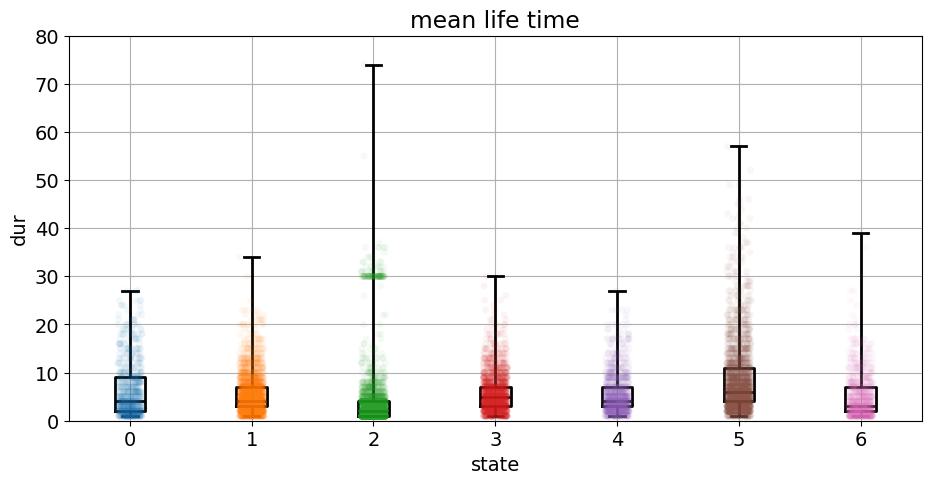

In [16]:
# mean lifetime
durs_stacked_df = pd.DataFrame({'dur':durs, 'state':st_list})
fig, axs = plt.subplots(1, 1, figsize=(11, 5), dpi=100)
ax = axs
sns.boxplot(
    data=durs_stacked_df, 
    x='state', y='dur', 
    fill=False, boxprops={'alpha':1.0}, whis=(0, 100), 
    width=0.25, color="0.0", linewidth=2, 
    ax=ax,
)
sns.stripplot(
    data=durs_stacked_df, 
    x='state', y='dur', 
    palette=sns.color_palette('tab10'), dodge=False, alpha=0.05, 
    ax=ax,
)
ax.set(title=f'mean life time', ylim=[0, 80])
ax.grid(True)

In [17]:
# directly taken from manasij's github
import numpy as np
from numpy import linalg as LA

class distance_FC(object):
    def __init__(self, FC1, FC2, eig_thresh=10**(-3)):
        self.FC1 = FC1
        self.FC2 = FC2
        self.eig_thresh = eig_thresh

        # ensure symmetric
        self.FC1 = self._ensure_symmetric(self.FC1)
        self.FC2 = self._ensure_symmetric(self.FC2)

    def _info(self, s):
        print('INFO: %s' % s)

    def _ensure_symmetric(self, Q):
        '''
        computation is sometimes not precise (round errors),
        so ensure matrices that are supposed to be
        symmetric are symmetric
        '''
        return (Q + np.transpose(Q))/2

    def _vectorize(self, Q):
        '''
        given a symmetric matrix (FC), return unique
        elements as an array. Ignore diagonal elements
        '''
        # extract lower triangular matrix
        tri = np.tril(Q, -1)

        vec = []
        for ii in range(1, tri.shape[0]):
            for jj in range(ii):
                vec.append(tri[ii, jj])
        
        return np.asarray(vec)

    def geodesic(self):
        '''
        dist = sqrt(trace(log^2(M)))
        M = Q_1^{-1/2}*Q_2*Q_1^{-1/2}
        '''
        try:        
            # compute Q_1^{-1/2} via eigen value decmposition
            u, s, _ = LA.svd(self.FC1, full_matrices=True)

            ## lift very small eigen values
            for ii, s_ii in enumerate(s):
                if s_ii < self.eig_thresh:
                    s[ii] = self.eig_thresh

            '''
            since FC1 is in S+, u = v, u^{-1} = u'
            FC1 = usu^(-1)
            FC1^{1/2} = u[s^{1/2}]u'
            FC1^{-1/2} = u[s^{-1/2}]u'
            '''
            FC1_mod = u @ np.diag(s**(-1/2)) @ np.transpose(u)
            M = FC1_mod @ self.FC2 @ FC1_mod

            '''
            trace = sum of eigenvalues;
            np.logm might have round errors,
            implement using svd instead
            '''
            _, s, _ = LA.svd(M, full_matrices=True)

            return np.sqrt(np.sum(np.log(s)**2))
        except:
            return np.nan

    def pearson(self):
        '''
        conventional Pearson distance between
        two FC matrices. The matrices are vectorized
        '''
        try:
            # vec1 = self._vectorize(self.FC1)
            # vec2 = self._vectorize(self.FC2)

            # return (1 - np.corrcoef(vec1, vec2)[0, 1])/2
            return 1 - np.corrcoef(
                self.FC1[np.tril_indices(self.FC1.shape[0], k=-1)], 
                self.FC2[np.tril_indices(self.FC2.shape[0], k=-1)]
            )[0, 1]
        except:
            return np.nan
        
    def cosine(self):
        '''
        cosine distance
        '''
        try:
            return sp.spatial.distance.cosine(
                self.FC1[np.tril_indices(self.FC1.shape[0], k=-1)], 
                self.FC2[np.tril_indices(self.FC2.shape[0], k=-1)]
            )
        except:
            return np.nan

In [18]:
# mean activity of states
# NOTE: set up 3ddeconvolve script in future
l = 0
mean_activity = np.zeros((args.num_rois, hmm.K))
fcs = np.zeros((args.num_rois, args.num_rois, hmm.K))
for idx_state in np.arange(hmm.K):
    ts_state = ts_all_stk[mask_all_stk_pca[:, 0], :]
    st_seq = (state_seq == idx_state)[mask_all_stk_pca[:, 0]]
    mean_activity[:, idx_state] = np.mean(ts_state[st_seq, :], axis=0)
    fcs[:, :, idx_state] = np.corrcoef(ts_state[st_seq, :], rowvar=False)
    # fcs[:, :, idx_state] -= np.diag(np.diag(fcs[:, :, idx_state]))
    
    # plt.figure(figsize=(25, 3))
    # plt.plot(st_seq)
    # plt.title(f'state {idx_state}')
    # plt.xlabel('time (sec)')
    
    l += len(np.where(st_seq)[0])
    print(idx_state, ts_state.shape, st_seq.shape, len(np.where(st_seq)[0]))

print(l)

# geodesic distance bw statewise fcs
dists = np.zeros((hmm.K, hmm.K)) * np.nan
for st_i, st_j in combinations(np.arange(hmm.K), 2):
    dists[st_j, st_i] = distance_FC(fcs[:, :, st_i], fcs[:, :, st_j]).geodesic()
    # dists[st_i, st_j] = np.nan

0 (56701, 172) (56701,) 4747
1 (56701, 172) (56701,) 12663
2 (56701, 172) (56701,) 0
3 (56701, 172) (56701,) 9949
4 (56701, 172) (56701,) 5748
5 (56701, 172) (56701,) 19414
6 (56701, 172) (56701,) 4180
56701


one of the states represents masked time points

[Text(0.5, 1.0, 'geodesic distance'),
 Text(0.5, 25.577777777777776, 'states'),
 Text(79.97777777777785, 0.5, 'states')]

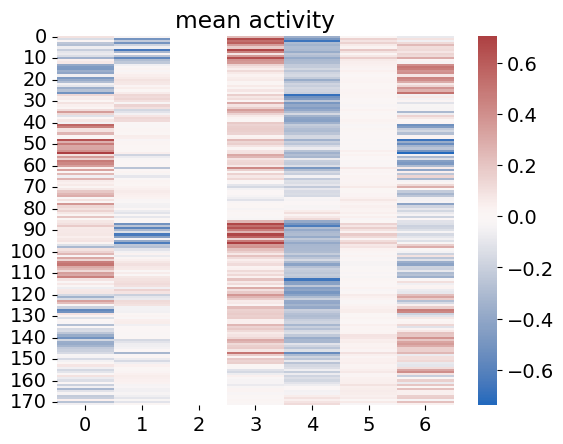

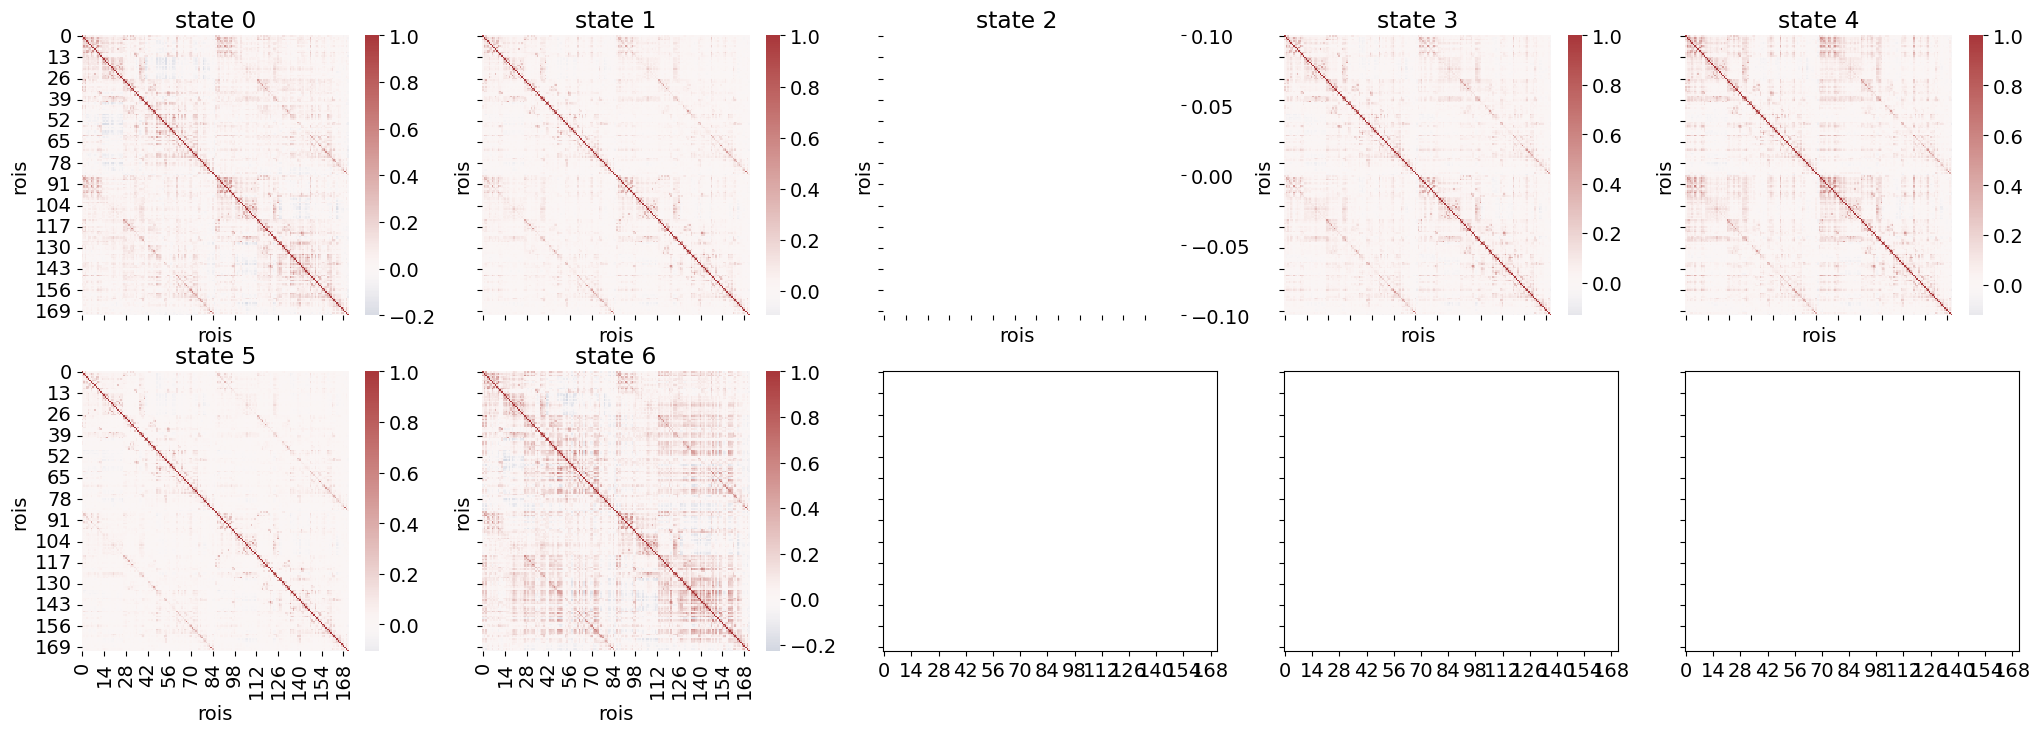

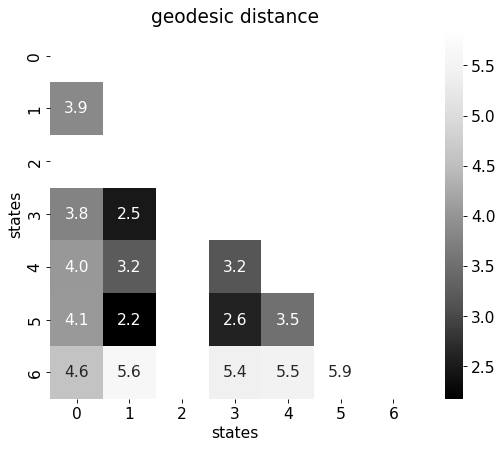

In [19]:
# mean activities of states
sns.heatmap(mean_activity, cmap=sns.color_palette("vlag", as_cmap=True), center=0)
plt.title('mean activity')

# fcs of states
colors = sns.color_palette('tab10')[:hmm.K]
nrows, ncols = int(np.ceil(args.num_states / 5)), 5
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5*ncols, 4*nrows), sharex=True, sharey=True)
for idx_state in range(args.num_states):
    r, c = idx_state // 5,  idx_state % 5
    ax = axs[r, c] if args.num_states > 5 else axs[c]
    
    sns.heatmap(fcs[:, :, idx_state], cmap=sns.color_palette("vlag", as_cmap=True), center=0, ax=ax)
    ax.set(title=f'state {idx_state}', xlabel='rois', ylabel='rois')

# geodesic dists bw fcs
fig, axs = plt.subplots(1, 1, figsize=(8, 6), dpi=80)
ax = axs
sns.heatmap(
    dists, square=True, 
    cmap='Greys_r', #center=0, 
    annot=True, fmt='.1f',
    ax=ax
)
ax.set(title='geodesic distance', xlabel='states', ylabel='states')

Question: till which order of statistic of timeseries are the states distinct; till first order (mean activity), or second order (fc), or more?

state wise fcs in every run, then can see distribution of distances between and within each state to see distinctness of states.

---

In [20]:
# runwise state ts + fcs
ts_pca_sample = deepcopy(ts_sample)
idx = 0
for sub, ses in tqdm(product(range(args.num_subs), range(args.num_sess))):
    for run in range(len(ts_sample[sub][ses])):
        ts_pca_sample[sub][ses][run] = (ts_all_pca[idx], mask_all_pca[idx])
        idx += 1

stats_sample = deepcopy(ts_sample)
for sub, ses in tqdm(product(range(args.num_subs), range(args.num_sess))):
    for run in range(len(ts_pca_sample[sub][ses])):
        ts_pca, mask_pca = ts_pca_sample[sub][ses][run]
        state_seq = hmm.most_likely_states(data=ts_pca, mask=mask_pca)
        
        ts, mask = ts_sample[sub][ses][run]
        
        mean_act = np.zeros((args.num_rois, hmm.K))
        fcs = np.zeros((args.num_rois, args.num_rois, hmm.K))
        for idx_state in np.arange(hmm.K):
            ts_state = ts[mask[:, 0], :]
            st_seq = (state_seq == idx_state)[mask[:, 0]]
            mean_act[:, idx_state] = np.mean(ts_state[st_seq, :], axis=0)
            fcs[:, :, idx_state] = np.corrcoef(ts_state[st_seq, :], rowvar=False)
            # fcs[:, :, idx_state] -= np.diag(np.diag(fcs[:, :, idx_state]))
        stats_sample[sub][ses][run] = (state_seq, mean_act, fcs)

30it [00:00, 3014.67it/s]
2it [00:00, 16.00it/s]

30it [00:01, 21.46it/s]


In [21]:
stats_df = pd.DataFrame(columns=['sub', 'ses', 'run', 'state', 'state_seq', 'present_states', 'mean_act', 'fc'])
for sub, ses in tqdm(product(range(args.num_subs), range(args.num_sess))):
    for run in range(len(stats_sample[sub][ses])):
        stats = stats_sample[sub][ses][run]
        for idx_state in np.arange(hmm.K):
            df = pd.DataFrame({
                'sub':[sub],
                'ses':[ses],
                'run':[run],
                'state':[idx_state],
                'state_seq':[state_seq],
                'present_states':[np.unique(stats[0])],
                'mean_act':[stats[1][:, idx_state]],
                'fc':[stats[2][:, :, idx_state]],
            })
            stats_df = pd.concat([stats_df, df])
            
# ---


4it [00:00, 33.31it/s]

30it [00:00, 35.78it/s]


In [22]:
stats_df

,sub,ses,run,state,state_seq,present_states,mean_act,fc
0,0,0,0,0,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[0, 1, 2, 3, 4, 5, 6]","[0.37413296218012804, -1.9488815155807906, -1....","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,..."
0,0,0,0,1,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[0, 1, 2, 3, 4, 5, 6]","[0.05346735746470256, -0.06160447991973056, 0....","[[1.0, 0.17689979286612184, 0.2356755861382793..."
0,0,0,0,2,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[0, 1, 2, 3, 4, 5, 6]","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,..."
0,0,0,0,3,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[0, 1, 2, 3, 4, 5, 6]","[0.03001562812208409, 0.44683459047568047, 0.4...","[[1.0, 0.12193241563512074, 0.4920101496328754..."
0,0,0,0,4,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[0, 1, 2, 3, 4, 5, 6]","[-0.17871276209795106, -0.4837262428549526, -0...","[[1.0, -0.4827635672718971, 0.0596770823491779..."
...,...,...,...,...,...,...,...,...
0,9,2,3,2,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[0, 1, 2, 3, 4, 5, 6]","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,..."
0,9,2,3,3,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[0, 1, 2, 3, 4, 5, 6]","[-0.07803382721797496, 0.6037795397369565, 0.6...","[[1.0, 0.21587131161355497, 0.0989007070527362..."
0,9,2,3,4,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[0, 1, 2, 3, 4, 5, 6]","[0.10069635998878403, -0.6011246556269282, -0....","[[1.0, 0.04861307122494801, -0.126725238045763..."
0,9,2,3,5,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[0, 1, 2, 3, 4, 5, 6]","[-0.009506827867460453, 0.17892460904728155, 0...","[[0.9999999999999999, -0.0555304025149041, 0.0..."


In [23]:
dists = [
    [
        []
        for _ in range(hmm.K)
    ]
    for _ in range(hmm.K)
]
for st_i, st_j in tqdm(zip(*np.tril_indices(hmm.K, k=0))):
    fcs_i = stats_df.loc[(stats_df['state'] == st_i)]['fc'].values
    fcs_j = stats_df.loc[(stats_df['state'] == st_j)]['fc'].values
    for fc_i, fc_j in list(product(fcs_i, fcs_j)):
        dists[st_i][st_j].append(distance_FC(fc_i, fc_j).pearson())    

28it [06:13, 13.34s/it]


28it [00:01, 22.17it/s]


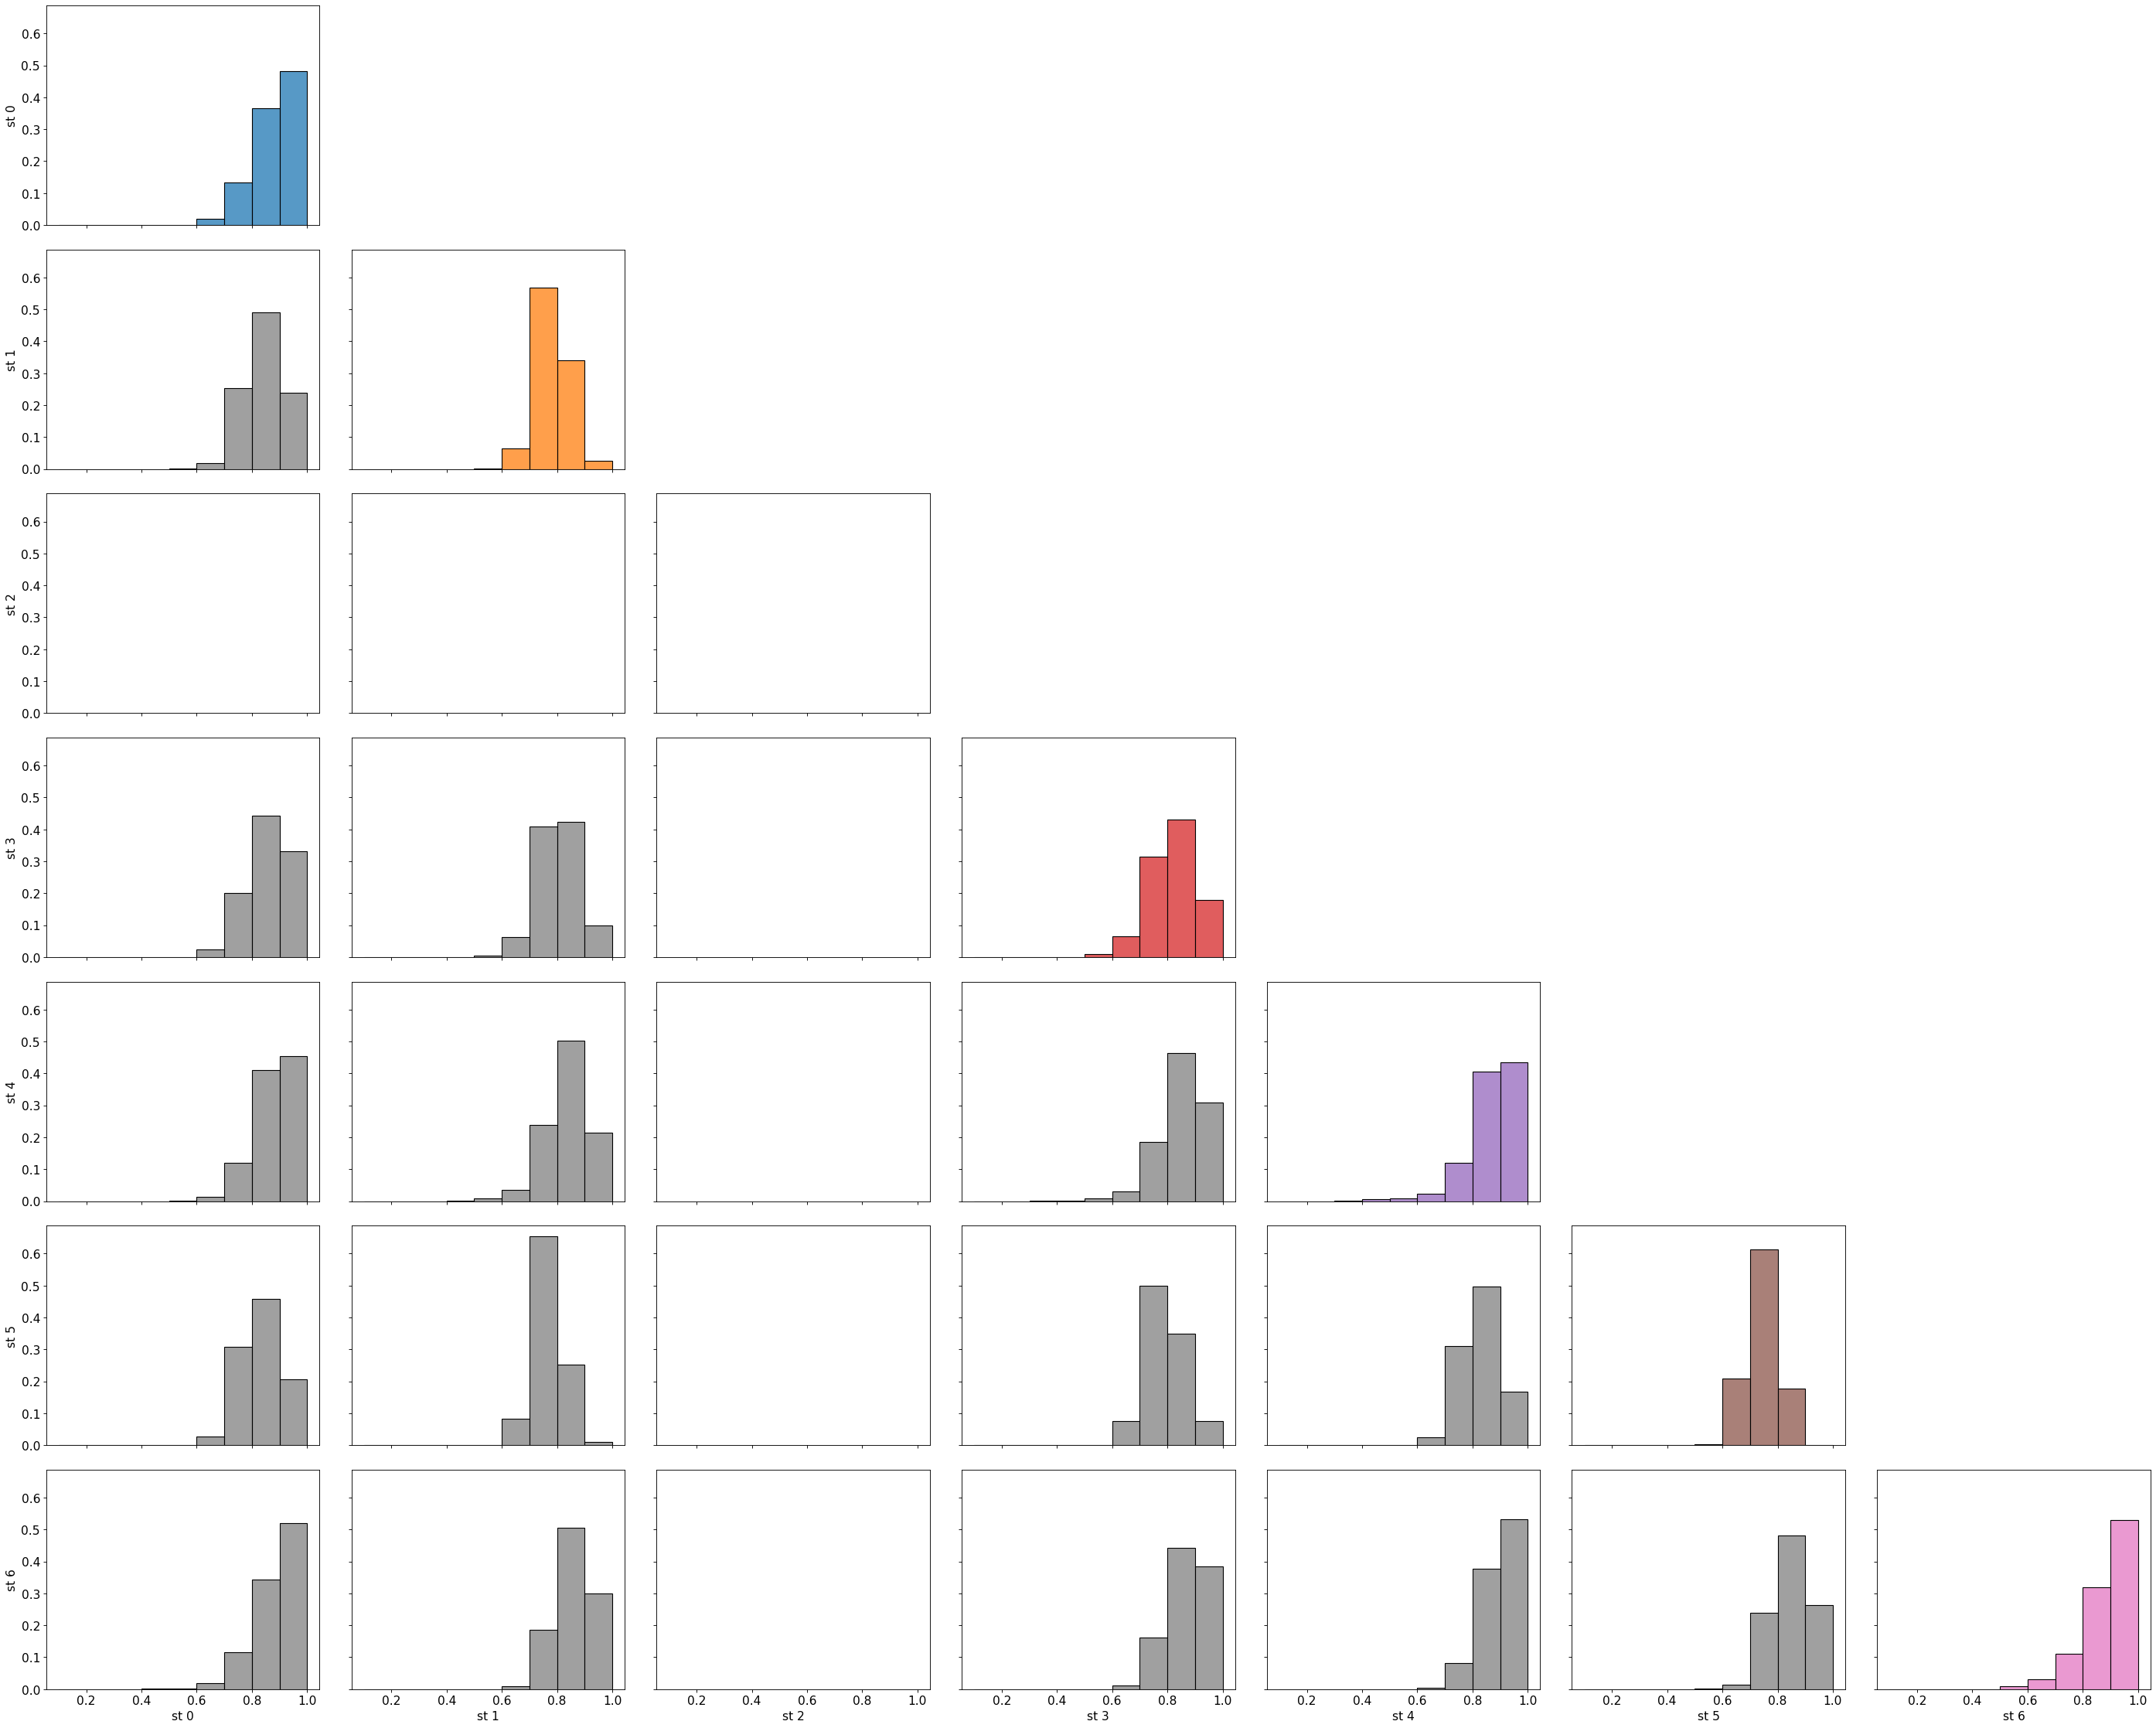

In [24]:
nrows, ncols = hmm.K, hmm.K
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5*ncols, 4*nrows), dpi=80, sharex=True, sharey=True)
fig.tight_layout()
for st_i, st_j in tqdm(zip(*np.tril_indices(hmm.K, k=0))):
    ax = axs[st_i, st_j]
    if st_j == 0: ax.set_ylabel(f'st {st_i}')
    if st_i == hmm.K-1: ax.set_xlabel(f'st {st_j}')
    color = colors[st_i] if st_i == st_j else 'Grey'
    sns.histplot(dists[st_i][st_j], stat='proportion', binwidth=0.1, binrange=[0.1, 1], color=color, ax=ax)

for st_i, st_j in zip(*np.triu_indices(hmm.K, k=1)):
    ax = axs[st_i, st_j]
    ax.remove()